# Replication of results from Anderson et al. 2016

## Initializing

Notes :
- sampling frequency
- initial parameters (grid search, iterative)


In [1]:
import numpy as np
import scipy.io
import math
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import pyhsmm_mvpa as hsmm

import os

%load_ext autoreload
%autoreload 2


# Initial fit

Reading the data

In [2]:
mat = scipy.io.loadmat('matlab/newbumps/starter.mat')

data = np.array(mat['normedscore10'])
starts = np.array(mat['x'][:,0]) -1#correcting to be 0 indexed
ends = np.array(mat['y'][:,0])-1#correcting to be 0 indexed
subjects = np.array(mat['subjects'])-1 #correcting to be 0 indexed

testing single fit

In [3]:
init = hsmm.hsmm(data, starts, ends)

In [44]:
initial_estimates = init.fit_single(1)

Estimating parameters


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:144: UserWarning: Using default parameters value for magnitudes and gamma
  warnings.warn('Using default parameters value for magnitudes and gamma')


Parameters estimated


In [45]:
initial_estimates

<xarray.Dataset>
Dimensions:      (stage: 2, params: 2, component: 10, bump: 1, samples: 300,
                  trial: 18271)
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  float64 -8.769e+04
    parameters   (stage, params) float64 2.0 33.46 2.0 17.67
    magnitudes   (component, bump) float64 -1.219 0.4162 ... 0.1688 -0.05549
    eventprobs   (samples, trial, bump) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [46]:
init.fit_single(1,parameters=initial_estimates.parameters.values, magnitudes=initial_estimates.magnitudes.values)

Estimating parameters
Parameters estimated


<xarray.Dataset>
Dimensions:      (stage: 2, params: 2, component: 10, bump: 1, samples: 300,
                  trial: 18271)
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  float64 -8.769e+04
    parameters   (stage, params) float64 2.0 33.46 2.0 17.67
    magnitudes   (component, bump) float64 -1.219 0.4162 ... 0.1688 -0.05549
    eventprobs   (samples, trial, bump) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [55]:
iterative_estimates = init.fit_iterative(2)

/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:150: UserWarning: Using default parameters value for magnitudes and gamma
  magnitudes = np.zeros((self.n_dims,n_bumps))


In [56]:
iterative_estimates = init.fit_iterative(2,parameters=iterative_estimates.parameters.values, magnitudes=iterative_estimates.magnitudes.values)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [58]:
magnitudes = iterative_estimates.parameters.values

In [59]:
magnitudes[~np.isnan(magnitudes)]

array([ 2.        , 32.90307305,  2.        , 18.22101704,  2.        ,
       10.3287971 ,  2.        , 21.62902911,  2.        , 16.91626388])

In [34]:
[[1,2],[3,4]] == None

False

In [54]:
init.fit_iterative(2,None)

UnboundLocalError: local variable 'pars' referenced before assignment

In [9]:
init.extract_results()

AttributeError: 'hsmm' object has no attribute 'likelihoods'

In [76]:
import matplotlib.pyplot as plt 
plt.plot(estimated_init.likelihoods-estimated_init.likelihoods[0],'o-')

NameError: name 'estimated_init' is not defined

In [22]:
result_init = hsmm.results(estimated_init, data, starts, ends)

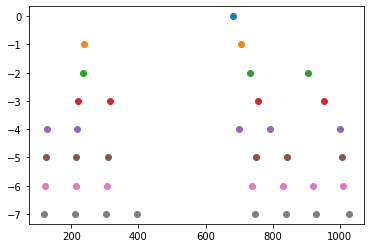

In [23]:
for nbump in np.arange(max_bumps):
    plt.plot(np.cumsum(result_init.bump_times(nbump)), -np.repeat(nbump, len(result_init.bump_times(nbump))),'o')

## Leave one out

In [ ]:
import multiprocessing as mp

#Looping over possible number of bumps
subjects_idx = np.unique(subjects)
likelihoods = []

for n_bumps in np.arange(max_bumps)+1:
    for subject in subjects_idx:
        print(f'Subject {subject} in bump {n_bumps}')
        #Extracting data from left out subject
        subjects_idx_loo = subjects_idx[subjects_idx != subject]

        starts_left_out_idx = np.array([starts[idx] for idx, s in enumerate(subjects) if s not in subjects_idx_loo])
        ends_left_out_idx = np.array([ends[idx] for idx, s in enumerate(subjects) if s not in subjects_idx_loo])

        #Correct starts indexes to account for reoved subject, whole indexing needs improvement
        starts_loo = np.concatenate([starts[starts < starts_left_out_idx[0]], starts[starts > ends_left_out_idx[-1]]-ends_left_out_idx[-1]+1])
        ends_loo = np.concatenate([ends[ends < starts_left_out_idx[0]], ends[ends > ends_left_out_idx[-1]]-ends_left_out_idx[-1]])
        ends_loo[-1] = ends_loo[-1]-1
        starts_left_out = np.array([start - starts_left_out_idx[0]  for start in starts if start >= starts_left_out_idx[0] and start <= ends_left_out_idx[-1]])
        ends_left_out = np.array([end - starts_left_out_idx[0]  for end in ends if end >= starts_left_out_idx[0] and end <= ends_left_out_idx[-1]])


        samples_loo = np.array([sample for idx,sample in enumerate(data) if idx < starts_left_out_idx[0] or idx > ends_left_out_idx[-1]])
        samples_left_out = np.array([sample for idx,sample in enumerate(data) if idx >= starts_left_out_idx[0] and idx <= ends_left_out_idx[-1]])
        #Fitting the HsMM using previous estimated parameters as initial parameters
        model = hsmm.hsmm(samples_loo, starts_loo, ends_loo, n_bumps, initializing=False,\
            magnitudes = estimated_init.magnitudes.sel(bumps=n_bumps).values[:,:n_bumps],
            parameters = estimated_init.parameters.sel(bumps=n_bumps).values[:n_bumps+1,:])
        model.fit()
        run = model.extract_results()
        
        model = hsmm.hsmm(samples_left_out, starts_left_out, ends_left_out, n_bumps, initializing=False,\
            magnitudes = run.magnitudes.values[:,:n_bumps],
            parameters = run.parameters.values[:n_bumps+1,:],
            threshold=0)
        model.fit()
        likelihoods.append([n_bumps, subject, model.extract_results().likelihoods.values])

In [12]:
import pandas as pd
n_bumps, subject, lkh = [],[],[]
for e in likelihoods:
    n_bumps.append(e[0])
    subject.append(e[1])
    lkh.append(e[2])
loo_results = pd.DataFrame({'n_bumps':n_bumps, 'subject':subject, 'likelihood':lkh})

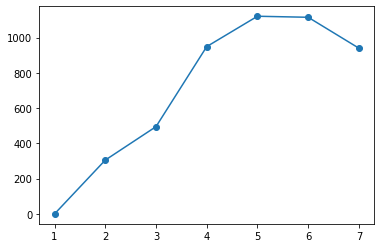

In [17]:
plt.plot(loo_results.groupby('n_bumps').likelihood.mean()-loo_results.groupby('n_bumps').likelihood.mean().values[0], 'o-')

In [ ]:
import multiprocessing as mp

#Looping over possible number of bumps
subjects_idx = np.unique(subjects)
likelihoods = []

for n_bumps in [1]:#np.arange(max_bumps)+1:
    for subject in subjects_idx:
        print(subject)
        #Extracting data from left out subject
        subjects_idx_loo = subjects_idx[subjects_idx != subject]
        subjects_loo = np.array([s for s in subjects if s not in subjects_idx_loo])
        starts_left_out_idx = np.array([starts[idx] for idx, s in enumerate(subjects) if s not in subjects_idx_loo])
        ends_left_out_idx = np.array([ends[idx] for idx, s in enumerate(subjects) if s not in subjects_idx_loo])

        #Correct starts indexes to account for reoved subject, whole indexing needs improvement
        starts_loo = np.concatenate([starts[starts < starts_left_out_idx[0]], starts[starts > ends_left_out_idx[-1]]-ends_left_out_idx[-1]+1])
        ends_loo = np.concatenate([ends[ends < starts_left_out_idx[0]], ends[ends > ends_left_out_idx[-1]]-ends_left_out_idx[-1]])
        starts_left_out = np.array([start - starts_left_out_idx[0]  for start in starts if start >= starts_left_out_idx[0] and start <= ends_left_out_idx[-1]])
        ends_left_out = np.array([end - starts_left_out_idx[0]  for end in ends if end >= starts_left_out_idx[0] and end <= ends_left_out_idx[-1]])


        samples_loo = np.array([sample for idx,sample in enumerate(data) if idx < starts_left_out_idx[0] or idx > ends_left_out_idx[-1]])
        samples_left_out = np.array([sample for idx,sample in enumerate(data) if idx >= starts_left_out_idx[0] and idx <= ends_left_out_idx[-1]])
        #Fitting the HsMM using previous estimated parameters as initial parameters
        model = hsmm.hsmm(samples_loo, starts_loo, ends_loo, n_bumps, initializing=False,\
            magnitudes = estimated_init.magnitudes.sel(bumps=n_bumps).values[:,:n_bumps],
            parameters = estimated_init.parameters.sel(bumps=n_bumps).values[:n_bumps+1,:])
        model.fit()
        run = model.extract_results()
        
        model = hsmm.hsmm(samples_left_out, starts_left_out, ends_left_out, n_bumps, initializing=False,\
            magnitudes = run.magnitudes.values[:,:n_bumps],
            parameters = run.parameters.values[:n_bumps+1,:],
            threshold=0)
        model.fit()
        likelihoods.append([n_bumps, subject, model.extract_results().likelihoods.values])

In [33]:
xr.Dataset(likelihoods)

TypeError: unhashable type: 'list'

In [26]:
import multiprocessing
cpus = multiprocessing.cpu_count()
subjects_idx = np.unique(subjects)


with multiprocessing.Pool(processes=cpus) as pool:
    test = pool.starmap(hsmm.LOOCV, [(data, starts, ends, 1+1, \
           subjects, 2, False,\
            result_init.estimated.sel(bumps=2).magnitudes.values[:,:1+1],\
            result_init.estimated.sel(bumps=2).parameters.values[:1+2,:],\
            5, 0,2),(data, starts, ends, 1+1, \
            subjects, 2, 2, False,\
            result_init.estimated.sel(bumps=2).magnitudes.values[:,:1+1],\
            result_init.estimated.sel(bumps=2).parameters.values[:1+2,:],\
            5, 0,2)])

TypeError: 'bool' object is not subscriptable

In [28]:
for i in zip([data, starts, ends, 1+1, \
           subjects, 2, False,\
            result_init.estimated.sel(bumps=2).magnitudes.values[:,:1+1],\
            result_init.estimated.sel(bumps=2).parameters.values[:1+2,:],\
            5, 0,2], [1,2]):
    print(i)


(array([[ 2.32248514, -1.14917481, -0.60884933, ..., -1.36036844,
        -0.52068168,  0.49856343],
       [ 2.57840517, -1.05168324, -0.49152389, ..., -1.41936989,
        -0.81817635,  0.21768737],
       [ 2.55645892, -1.03697521, -0.19768004, ..., -1.21883663,
        -0.52054663, -0.14074053],
       ...,
       [ 0.05779474,  1.55007376,  0.84760378, ...,  1.84612582,
         1.74275287, -0.89558476],
       [-0.22107025,  1.44579805,  0.91386165, ...,  1.89623787,
         1.6575547 , -0.67290222],
       [-0.14932312,  1.23868402,  1.75018803, ...,  1.78666059,
         1.28486489, -0.74203936]]), 1)
(array([      0,     135,     238, ..., 1950003, 1950143, 1950317],
      dtype=int32), 2)


In [13]:
result_init.estimated

<xarray.Dataset>
Dimensions:      (bumps: 8, stage: 9, params: 2, component: 10, bump: 8)
Dimensions without coordinates: bumps, stage, params, component, bump
Data variables:
    likelihoods  (bumps) float64 ...
    parameters   (bumps, stage, params) float64 ...
    magnitudes   (bumps, component, bump) float64 ...

In [18]:
hsmm.LOOCV(data, starts, ends, 1+1, \
           subjects, 1, initializing=False,\
            magnitudes = result_init.estimated.sel(bumps=2).magnitudes.values[:,:1+1],
            parameters = result_init.estimated.sel(bumps=2).parameters.values[:1+2,:],
            threshold=0)

<xarray.Dataset>
Dimensions:      (stage: 3, params: 2, component: 10, bump: 2, samples: 299,
                  trial: 17360)
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  float64 -8.283e+04
    parameters   (stage, params) float64 2.0 20.16 2.0 20.18 2.0 7.79
    magnitudes   (component, bump) float64 0.6424 -0.3666 ... 0.03213 0.01526
    eventprobs   (samples, trial, bump) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0


TypeError: __init__() should return None, not 'numpy.ndarray'

In [162]:
test.fit()

In [164]:
test.extract_results()

<xarray.Dataset>
Dimensions:      (stage: 3, params: 2, component: 10, bump: 2, samples: 300,
                  trial: 17360)
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  float64 -8.178e+04
    parameters   (stage, params) float64 2.0 19.64 2.0 13.82 2.0 15.14
    magnitudes   (component, bump) float64 0.684 -0.6695 ... 0.01096 0.02759
    eventprobs   (samples, trial, bump) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [ ]:
hsmm.hsmm(samples_loo, starts_loo, ends_loo, n_bumps, False, estimated_init.magnitudes.sel(bumps=n_bumps).values,\
            estimated_init.parameters.sel(bumps=n_bumps).values).fit()

array([[ 0.89692239, -1.26779378],
       [-1.29957774,  0.49669005],
       [-0.01602858, -0.02013524],
       [-0.38856808,  0.08953187],
       [-1.03444104, -0.2609585 ],
       [ 0.54950808, -0.00801178],
       [-0.85309574, -0.07261229],
       [-0.31619572,  0.787061  ],
       [-0.21046378,  0.18849462],
       [ 0.04826478, -0.22203642]])

In [ ]:
bump0.fit()


In [ ]:
stop

In [ ]:
import xarray as xr

In [ ]:
bump0.save_fit('test')

In [ ]:
bump0.extract_results()

In [ ]:
bump2 = hsmm.hsmm(data, starts, ends, 3)
bump2.fit()
bump2.extract_results()

In [ ]:
estimated = bump1.extract_results()

In [ ]:
bump1.durations

In [ ]:
import numpy as np
import scipy.io
import math
import pandas as pd
import matplotlib.pyplot as plt
import HsMM_functions_0indexed_class as hsmm
import xarray as xr
import multiprocessing
import os

mat = scipy.io.loadmat('newbumps/starter.mat')
starts = np.array(mat['x'][:,0]) -1#correcting to be 0 indexed
ends = np.array(mat['y'][:,0])-1#correcting to be 0 indexed
data = np.array(mat['normedscore10'])
subjects = np.array(mat['subjects'])-1 #correcting to be 0 indexed
subjects_idx = np.unique(subjects)#participant should be numerical and in a continuous range
n_subjects = len(np.unique(subjects))

dur = [ends[i] - starts[i]+1 for i in np.arange(len(starts))]#storing duration of trials
ntrials = len(dur)
max_dur = np.max(dur)
min_dur = np.min(dur)
max_bumps = math.floor(min_dur/5)
n_dims = np.shape(data)[1] #N of components
bumps = hsmm.calc_bumps(data)
width = 5 #bump width, function of sampling rate

if 'estimation_init_0index_updated.nc' in os.listdir():
    estimation_init = xr.open_dataset('estimation_init_0index.nc')
else:
    lkhs, mags, params, eventprobs = np.empty((max_bumps)),np.empty((max_bumps, n_dims, max_bumps)),np.empty((max_bumps, max_bumps+1, 2)),np.empty((max_bumps, max_dur, ntrials, max_bumps))
    for i in np.arange(max_bumps):
        n_bump = i + 1
        params_init = np.tile([2, math.ceil(max_dur)/(n_bump+1)/2], (n_bump+1,1))
        print(i)# Just to keep track but can be removed or enhanced
        lkhs[i], mags[i,:,:n_bump], params[i,:i+2], eventprobs[i,:,:,:n_bump] = \
             hsmm.hsmmEEG(bumps, starts, ends, \
                np.zeros((n_dims,n_bump)), params_init, width, 1)

    xrlikelihoods = xr.DataArray(lkhs, dims=("n_bumps"), name="likelihoods")
    xrparams = xr.DataArray(params, dims=("n_bumps","stage",'params'), name="parameters")
    xrmags = xr.DataArray(mags, dims=("n_bumps","component","bump"), name="magnitudes")
    xreventprobs =  xr.DataArray(eventprobs, dims=("n_bumps","samples",'trial','bump'), name="eventprobs")

    estimation_init = xr.merge((xrlikelihoods,xrparams,xrmags,xreventprobs))
    estimation_init.to_netcdf("estimation_init_0index_updated.nc")

In [ ]:
estimation_init.to_netcdf("estimation_init_0index_latest.nc")

In [ ]:
a = np.array((2,2,2,2))
a.tolist()+[1]

### Leave one out

In [ ]:
len(subjects_idx[subjects_idx != subject])

In [ ]:
len(starts) - len(ends)

In [ ]:
starts_loo

In [ ]:
len(data[:,0]) == len(np.array(samples_left_out[:,0])+np.array(samples_loo[:,0]))

In [ ]:
plt.figure(dpi=300)
plt.plot(ends_loo,starts_loo,'.')
plt.plot(starts_loo,starts_loo,'-')

In [ ]:
#for the loo I leave out the event_probs as the array is then too big
lkhs_loo, mags_loo, params_loo = np.empty((max_bumps,n_subjects)),np.empty((max_bumps,n_subjects , n_dims, max_bumps)),\
        np.empty((max_bumps,n_subjects , max_bumps+1, 2))

#Looping over possible number of bumps
for i in np.arange(1):#max_bumps):
    n_bumps = i + 1  #ptyhon indexing
    best_likelihood = np.empty((n_subjects,1))
    best_bump_mag = np.empty((n_dims,n_bumps,n_subjects))
    best_gamma = np.empty((n_bumps+1, 2, n_subjects))
    
    for subject in subjects_idx:
        print(subject)
        #Extracting data from left out subject
        subjects_idx_loo = subjects_idx[subjects_idx != subject]
        
        starts_loo = np.array([starts[idx][0] for idx, s in enumerate(subjects) if s in subjects_idx_loo])
        ends_loo = np.array([ends[idx][0]  for idx, s in enumerate(subjects) if s in subjects_idx_loo])
        
        starts_left_out = np.array([starts[idx][0] for idx, s in enumerate(subjects) if s not in subjects_idx_loo])
        ends_left_out = np.array([ends[idx][0] for idx, s in enumerate(subjects) if s not in subjects_idx_loo])
        
        samples_loo = np.array([sample for idx,sample in enumerate(data) if idx+1 < starts_left_out[0] or idx+1 > ends_left_out[-1]])
        samples_left_out = np.array([sample for idx,sample in enumerate(data) if idx+1 >= starts_left_out[0] and idx+1 <= ends_left_out[-1]])
        
        #Fitting the HsMM using previous estimated parameters as initial parameters
        bumps_loo = hsmm.calc_bumps(samples_loo)
        
        lkhs_loo[i,subject], mags_loo[i,subject,:,:n_bump], params_loo[i,subject,:i+2], _ = hsmm.hsmmEEG(\
            bumps_loo, starts_loo, ends_loo, estimation_init.magnitudes.sel(n_bumps=i).values,\
            estimation_init.parameters.sel(n_bumps=i).values, width, 1)

        
        
        
    #params_init = np.tile([2, math.ceil(max_dur)/(n_bump+1)/2], (n_bump+1,1))
    #print(i)# Just to keep track but can be removed or enhanced
    #lkhs[i], mags[i,:,:i+1], params[i,:i+2], eventprobs[i,:,:,:i+1] = \
     #    hsmm.hsmmEEG(bumps, starts[:,0], ends[:,0], \
     #       np.zeros((n_dims,n_bump)), params_init, width, 1)

#xrlikelihoods = xr.DataArray(lkhs, dims=("n_bumps"), name="likelihoods")
#xrparams = xr.DataArray(params, dims=("n_bumps","stage",'params'), name="parameters")
#xrmags = xr.DataArray(mags, dims=("n_bumps","component","bump"), name="magnitudes")
#xreventprobs =  xr.DataArray(eventprobs, dims=("n_bumps","samples",'trial','bump'), name="eventprobs")

#estimation = xr.merge((xrlikelihoods,xrparams,xrmags,xreventprobs))
#estimation.to_netcdf("estimation.nc")

In [ ]:
ntrials-len(starts_left_out)

In [ ]:
len(starts_left_out)

In [ ]:
xrlikelihoods = xr.DataArray(lkhs, dims=("n_bumps"), name="likelihoods")
xrparams = xr.DataArray(params, dims=("n_bumps","stage",'params'), name="parameters")
xrmags = xr.DataArray(mags, dims=("n_bumps","component","bump"), name="magnitudes")
xreventprobs =  xr.DataArray(eventprobs, dims=("n_bumps","samples",'trial','bump'), name="eventprobs")

estimation = xr.merge((xrlikelihoods,xrparams,xrmags,xreventprobs))

In [ ]:
plt.plot(estimation_init.likelihoods,'-o')


In [ ]:
len(dur)

In [ ]:
np.shape(params)

In [ ]:
np.random.randn(2, 3)

In [ ]:
import xarray as xr 

data = xr.DataArray(np.random.randn(2, 3), dims=("x", "y"), coords={"x": [10, 20]})
data

In [ ]:
xrparams = xr.DataArray(params, dims=("n_bumps","stage",'params'))
xrmags = xr.DataArray(params, dims=("n_bumps","stage",'params'))

In [ ]:
test

In [ ]:
list_params = [x for x in params]

In [ ]:
params.reshape(2,3, 2).T

In [ ]:
params = np.array(params)

In [ ]:
import numpy as np
import scipy.io
import math
import pandas as pd
import matplotlib.pyplot as plt
import HsMM_functions as hsmm
import multiprocessing

def run_hsmm(bump):
    mat = scipy.io.loadmat('newbumps/starter.mat')
    starts = mat['x'] 
    ends = mat['y']
    data = mat['normedscore10']
    subjects = mat['subjects']

    dur = [ends[i] - starts[i] for i in np.arange(len(starts))]#storing duration of trials

    max_dur = np.max(dur)
    min_dur = np.min(dur)
    max_bumps = math.floor(min_dur/5)

    lkhs, mags, params, eventprobs = np.nan(max_bumps), [], [], []
    n_dims = np.shape(data)[1] #N of components
    bumps = hsmm.calc_bumps(data)
    width = 5
    params_init = np.tile([2, math.ceil(max_dur)/(n_bump+1)/2], (n_bump+1,1))
    print(bump)# Just to keep track but can be removed
    lkhs[bump-1], mags_temp, params_temp, eventprobs_temp = \
         hsmm.hsmmEEG(bumps, starts[:,0], ends[:,0], \
            np.nan((n_dims,bump)), params_init, width, 1)
    mags.append(mags_temp)
    params.append(params_temp)
    eventprobs.append(eventprobs_temp)

bumps = [x for x in np.arange(max_bumps)+1]

cpus = multiprocessing.cpu_count()

with multiprocessing.Pool(processes=cpus) as pool:
    pool.map(run_hsmm, bumps)
    


estim_df = pd.DataFrame({ 'mags':mags, 'params':params, 'eventprobs':eventprobs})
estim_df.to_pickle('estimated_8.pkl')
np.save('lkhs_8',lkhs)



In [ ]:
estimated = pd.read_pickle('estimated_8.pkl')

In [ ]:
estimated

In [ ]:
plt.plot(np.arange(1, len(estimated['lkhs'])+1), estimated['lkhs'], '-o')


In [ ]:
estimated['scales'] = [nbumps[:,1]*20 for nbumps in estimated['params']]

In [ ]:
i = 0
for stages in estimated['scales']:
    bumps = len(stages)-1
    plt.plot(np.array(stages[:-1] + 50).cumsum(), np.repeat(i, len(stages)-1), 'o', markersize=25)
    #plt.plot(bump, np.repeat(ys, len(bump)), 'o', markersize=25)
    i -= 1

In [ ]:
plt.plot(np.mean(estimated.eventprobs[1], axis=1))

In [ ]:
estimated['scales']

In [ ]:
np.shape(estimated.eventprobs[3])

In [ ]:
latencies_states = []
latencies_bumps = []
for nbump in estimated['scales']:
    print(len(nbump))
    i = 0
    lat_stages = []
    lat_bumps = []
    for stage in nbump:
        if i == 0: 
            lat_stages.append(0)
        elif i > 0 and i < len(nbump)-1 :
            lat_stages.append(stage + lat_stages[i-1]+50)
            lat_bumps.append(stage + lat_stages[i-1])
        else :
            lat_stages.append(1000)
        i += 1
    latencies_states.append(lat_stages)
    latencies_bumps.append(lat_bumps)

In [ ]:
i = 0
for bump, stage in zip(latencies_bumps, latencies_states):
    ys = i
    plt.plot(stage, np.repeat(ys, len(stage)), '-')
    plt.plot(bump, np.repeat(ys, len(bump)), 'o', markersize=25)
    i -= 1

In [ ]:
for nbump in estimated.scales:
    plt.plot(stage, np.repeat(ys, len(stage)), '-')


In [ ]:
[x[:,1]*10 for x in estimated.params]

## estimated.mags[4]

In [ ]:
plt.plot(np.mean(estimated['eventprobs'][1], axis=0)[:,0])

In [ ]:
np.shape(estimated.eventprobs[1])

In [ ]:
max_d = 299
nstates = 5

for states in np.arange(8):
    averagepos = np.mean
    
    
np.hstack((np.sum( \
            np.tile(np.arange(1,max_d+1)[np.newaxis].T, (1, nstates))\
            * np.mean(estimated.eventprobs[4], axis=1).reshape(max_d, nstates,\
            order="F").copy(), axis=0), np.mean(durations)))

In [ ]:
np.mean(estimated.eventprobs[4], axis=1).reshape(max_d, nstates,\
            order="F").copy()

In [ ]:
import scipy.io
import math


mat = scipy.io.loadmat('newbumps/starter.mat')
starts = mat['x'] 
ends = mat['y']
data = mat['normedscore10']
subjects = mat['subjects']

dur = [ends[i] - starts[i] for i in np.arange(len(starts))]#storing duration of trials

max_dur = np.max(dur)
min_dur = np.min(dur)
max_bumps = math.floor(min_dur/5)

lkhs, mags, params, eventprobs = np.nan(max_bumps), [], [], []
n_dims = np.shape(data)[1] #N of components
width = 5

In [ ]:
np.hstack((np.sum( \
            np.tile(np.arange(1,max_d+1)[np.newaxis].T, (1, nstates))\
            * np.mean(estimated.eventprobs[4], axis=1).reshape(max_d, nstates,\
            order="F").copy(), axis=0), np.mean(durations)))

In [ ]:


averagepos = 

In [ ]:
np.shape(estimated.eventprobs[4])

In [ ]:
import HsMM_functions as hsmm


In [ ]:
hsmm.gamma_params(np.asarray(estimated.eventprobs), dur, 2, max_d, width)

In [ ]:
np.shape(estimated.eventprobs[0])

In [ ]:
eventprobs = []
for nbump in np.arange(len(estimated.eventprobs)):
    eventprobs.append(estimated.eventprobs[nbump])

In [ ]:
eventprobs